Import the libraries

In [1]:
import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

# Enable CUDA GPU usage
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


import numpy as np
import pandas as pd
from keras import layers
import tensorflow as tf

from PIL import Image

# Configure TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Physical devices found:", physical_devices)
if physical_devices:
    try:
        # Enable memory growth to avoid allocating all GPU memory at once
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"GPU(s) available: {len(physical_devices)}")
        print(f"GPU names: {[device.name for device in physical_devices]}")
    except RuntimeError as e:
        print("Error configuring GPU:")
        print(e)
else:
    print("No GPU found, using CPU")


# Set mixed precision for better performance (optional)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

Physical devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU(s) available: 1
GPU names: ['/physical_device:GPU:0']


In [ ]:
#### For reproducibility

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

Define image properties

In [2]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [3]:
trainFilesPath = './DataFiles/train/'
testFilesPath = './DataFiles/test/'

Prepare dataset for training model

In [4]:
filenames=os.listdir(trainFilesPath)
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

(100, 2)


<Axes: xlabel='category'>

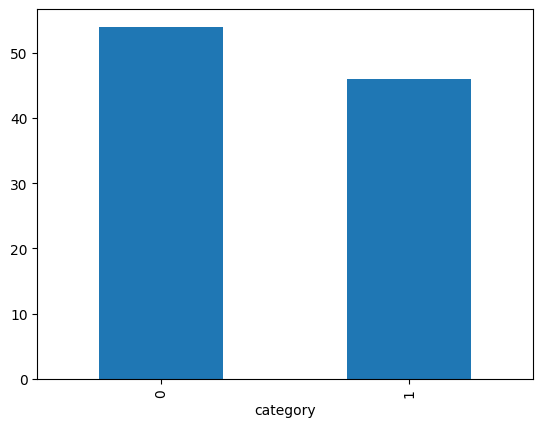

In [5]:
# print(df.shape)
# print(df.head())

## select 100 rows from the dataframe 
df = df.sample(100)
print(df.shape)

## print the description of the dataframe by considering only the category column as categorical data
# print(df['category'].astype('category').describe())

### visualize the distribution of the categories in the dataframe by using a bar plot
df['category'].value_counts().plot(kind='bar')

Create the neural net model

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

I0000 00:00:1771676990.111259   92975 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9452 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


Analyzing model

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,942,786 (49.37 MB)

 Trainable params: 12,941,314 (49.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

Define callbacks and learning rate:

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)


# learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

callbacks = [earlystop,learning_rate_reduction]

Manage data

In [ ]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
#### test DF
train_df = train_df.reset_index(drop=True)

validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

Test data preparation

In [12]:
#### Test DF
test_filenames = os.listdir(testFilesPath)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

Training and validation data generator

In [13]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

# train_generator = train_datagen.flow_from_dataframe(train_df,
#                                                  "./dogs-vs-cats/train/",
#                                                  x_col='filename',
#                                                  y_col='category',
#                                                  target_size=Image_Size,
#                                                  class_mode='categorical',
#                                                  batch_size=batch_size)


train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 trainFilesPath,  # Use defined variable
                                                 x_col='filename',
                                                 y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)


validation_datagen = ImageDataGenerator(rescale=1./255)
# validation_generator = validation_datagen.flow_from_dataframe(
#     validate_df, 
#     "./dogs-vs-cats/train/", 
#     x_col='filename',
#     y_col='category',
#     target_size=Image_Size,
#     class_mode='categorical',
#     batch_size=batch_size
# )


validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    trainFilesPath,  # Use defined variable
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)


test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

# test_generator = train_datagen.flow_from_dataframe(train_df,
#                                                  "./dogs-vs-cats/test/",x_col='filename',y_col='category',
#                                                  target_size=Image_Size,
#                                                  class_mode='categorical',
#                                                  batch_size=batch_size)


test_generator = test_datagen.flow_from_dataframe(test_df,  # Use test_df
                                                 testFilesPath,  # Use defined variable
                                                 x_col='filename',
                                                 target_size=Image_Size,
                                                 class_mode=None,  # No labels for test
                                                 batch_size=batch_size,
                                                 shuffle=False)


Found 80 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


Model Training

In [14]:

epochs=10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10


: 

Save the model

In [ ]:
model.save("model1_catsVSdogs_10epoch.h5")

Make categorical prediction

In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

AttributeError: 'Sequential' object has no attribute 'predict_generator'

Convert labels to categories

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

NameError: name 'predict' is not defined

Visualize the prediction results:

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(testFilesPath + filename, target_size=Image_Size)  # Fixed path
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Test your model performance on custom data

In [ ]:
# results={
#     0:'cat',
#     1:'dog'
# }

In [ ]:
# # im=Image.open("__image_path_TO_custom_image")
# # im=im.resize(Image_Size)
# # im=np.expand_dims(im,axis=0)
# # im=np.array(im)
# # im=im/255
# # pred_probs = model.predict(im)
# # pred = np.argmax(pred_probs, axis=-1)[0]
# # print(pred, results[pred])


# # Replace with actual image path
# image_path = "__image_path_TO_custom_image"  # Define your actual path here
# im = Image.open(image_path)
# im = im.resize(Image_Size)
# im = np.expand_dims(im, axis=0)
# im = np.array(im)
# im = im / 255
# pred_probs = model.predict(im)
# pred = np.argmax(pred_probs, axis=-1)[0]
# print(f"Prediction: {pred}, Class: {results[pred]}")

FileNotFoundError: [Errno 2] No such file or directory: '__image_path_TO_custom_image'